In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

from jax.scipy.integrate import trapezoid
from jax.scipy.special import erf

from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

In [2]:
# Seeding all Random Number Generation during the RL Training for Reproducibility

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 25.0
chi = 0.65
kerr = 0.002
gamma = 1/100
time_coeff = 10.0
snr_coeff = 10.0
rough_max_photons = 31
rough_max_amp_scaled = 1/0.43
actual_max_photons = rough_max_photons * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {rough_max_photons}")
print(f"Actual Max Photons: {actual_max_photons}")
ideal_photon = 1e-2
scaling_factor = 7.5
gamma_I = 1/500
num_t1 = 12.0
photon_gamma = 1/2000
init_fid = 1 - 1e-3

batchsize = 64
num_envs = 8
num_updates = 1000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": False,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 31
Actual Max Photons: 30.573151382405857


In [9]:
def t1_duration(kappa, res_scale_factor, tau_0):
    return (
        -2
        / kappa
        * jnp.log(1 - 1 / res_scale_factor * (1.0 - jnp.exp(-0.5 * kappa * tau_0)))
    )


def t3_duration(kappa, res_scale_factor):
    return -2 / kappa * jnp.log(res_scale_factor / (1.0 + res_scale_factor))

def pF(x):
    return -jnp.log10(1 - x)

def get_fidelity_curves(
    kappa,
    chi,
    N0,
    res_scale_factor,
    tau_0,
    init_fid,
    gamma_M,
    b,
    mu_s,
    num_t1,
    plot_curves: Optional[bool] = True,
    action: Optional[jnp.ndarray] = None
):  
    batch_size = 1
    ind = 0

    env = BatchedPhotonLangevinReadoutEnv(
        kappa=kappa,
        chi=chi,
        batchsize=batch_size,
        kerr=kerr,
        gamma=gamma,
        time_coeff=time_coeff,
        snr_coeff=snr_coeff,
        rough_max_photons=N0,
        actual_max_photons=actual_max_photons,
        rough_max_amp_scaled=res_scale_factor,
        ideal_photon=ideal_photon,
        scaling_factor=scaling_factor,
        gamma_I=gamma_I,
        num_t1=num_t1,
        photon_gamma=photon_gamma,
        init_fid=init_fid
    )

    ts = env.ts_sim

    batch_action = jnp.tile(action, (batch_size, 1))
    batched_results = env.batched_results(batch_action)
    max_pf, max_photons, photon_reset_time, b_pf, b_higher_photons = env.batched_extract_values(batched_results)
    real_pf = b_pf[0]

    t1 = t1_duration(kappa, res_scale_factor, tau_0)
    t3 = t3_duration(kappa, res_scale_factor)
    decay_factor = 1. - jnp.exp(-0.5 * kappa * tau_0)

    u = res_scale_factor
    N0_u = N0 * u ** 2
    N0_f = N0 * decay_factor ** 2

    integrated_decay_t1 = (gamma_M + b * N0_u) * t1 + 4 * b * N0_u / kappa * (jnp.exp(-0.5*kappa*t1) - 1.) - b * N0_u / kappa * (jnp.exp(-kappa * t1) - 1.)
    fidelity_high_t1 = init_fid * jnp.exp(-integrated_decay_t1)

    fidelity_i2 = fidelity_high_t1 * jnp.exp(-(gamma_M + b * N0_f) * (ts - t1))
    b1 = u * (chi / kappa * (1. - jnp.exp(-0.5 * kappa * t1)) - 0.5 * chi * t1 * jnp.exp(-0.5 * kappa * t1)) / decay_factor

    separation_i2 = 2 * jnp.sqrt(N0_f) * (
        b1 * jnp.exp(-0.5 * kappa * (ts - t1)) + chi / kappa * (1. - jnp.exp(-0.5 * kappa * (ts - t1)))
    )
    opt_fidelity = 0.5 * (1 + erf(mu_s * separation_i2)) * fidelity_i2

    integrated_decay_ts = (gamma_M + b * N0) * ts + 4 * b * N0 / kappa * (jnp.exp(-0.5 * kappa * ts) - 1.) - b * N0 / kappa * (jnp.exp(-kappa * ts) - 1.)
    fidelity_normal = init_fid * jnp.exp(-integrated_decay_ts)
    separation_normal = 2 * jnp.sqrt(N0) * (
        chi / kappa * (1. - jnp.exp(-0.5 * kappa * ts)) - 0.5 * chi * ts * jnp.exp(-0.5 * kappa * ts)
    )
    exp_fidelity = 0.5 * (1 + erf(mu_s * separation_normal)) * fidelity_normal

    integrated_high_decay_ts = (gamma_M + b * N0_u) * ts + 4 * b * N0_u / kappa * (jnp.exp(-0.5 * kappa * ts) - 1.) - b * N0_u / kappa * (jnp.exp(-kappa * ts) - 1.)
    fidelity_high = init_fid * jnp.exp(-integrated_high_decay_ts)
    separation_high = 2 * jnp.sqrt(N0_u) * (
        chi / kappa * (1. - jnp.exp(-0.5 * kappa * ts)) - 0.5 * chi * ts * jnp.exp(-0.5 * kappa * ts)
    )
    high_fidelity = 0.5 * (1 + erf(mu_s * separation_high)) * fidelity_high

    peak_opt_fidelity = jnp.max(opt_fidelity)
    peak_opt_fidelity_time = ts[jnp.argmax(opt_fidelity)]

    peak_exp_fidelity = jnp.max(exp_fidelity)
    peak_exp_fidelity_time = ts[jnp.argmax(exp_fidelity)]

    peak_real_fidelity = jnp.max(real_pf)
    peak_real_fidelity_time = ts[jnp.argmax(real_pf)]

    peak_high_fidelity = jnp.max(high_fidelity)
    peak_high_fidelity_time = ts[jnp.argmax(high_fidelity)]

    max_fidelity = init_fid * jnp.exp(-gamma_M * ts)

    if plot_curves:
        fig, ax = plt.subplots(1, figsize=(10., 8.0))

        ax.plot(ts, pF(exp_fidelity), label='exp pF', color='red')
        ax.plot(ts, pF(opt_fidelity), label='opt pF', color='green')
        ax.plot(ts, pF(max_fidelity), label='max pF', color='blue')
        ax.plot(ts, pF(high_fidelity), label='high pF', color='purple')
        ax.plot(ts, real_pf, label='action pF', color='orange')
        ax.axvline(x=t1, color='grey', linestyle='dashed', label='t1')
        ax.axvline(x=peak_exp_fidelity_time, color='red', linestyle='dashed', label=f'exp t2: {int(peak_exp_fidelity_time * 1e3) / 1e3}us')
        ax.axvline(x=peak_high_fidelity_time, color='purple', linestyle='dashed', label=f'high t2: {int(peak_high_fidelity_time * 1e3) / 1e3}us')
        ax.axvline(x=peak_opt_fidelity_time, color='green', linestyle='dashed', label=f'opt t2: {int(peak_opt_fidelity_time * 1e3) / 1e3}us')
        ax.axvline(x=peak_real_fidelity_time, color='orange', linestyle='dashed', label=f'real t2: {int(peak_real_fidelity_time * 1e3) / 1e3}us')
        ax.axhline(y=peak_exp_fidelity, color='red', linestyle='dashed', label=f'exp max fid: {int(peak_exp_fidelity * 1e3) / 1e3}')
        ax.axhline(y=peak_high_fidelity, color='purple', linestyle='dashed', label=f'high max fid: {int(peak_high_fidelity * 1e3) / 1e3}')
        ax.axhline(y=peak_opt_fidelity, color='green', linestyle='dashed', label=f'opt max fid: {int(peak_opt_fidelity * 1e3) / 1e3}')
        ax.axhline(y=peak_real_fidelity, color='orange', linestyle='dashed', label=f'real max fid: {int(peak_real_fidelity * 1e3) / 1e3}')
        ax.set_xlabel('Time (us)')
        ax.set_ylabel('pF')
        ax.set_title('pF vs Time (us)')
        ax.legend()

        print(f"Kappa: {kappa} MHz")
        print(f"1/kappa: {1000 * 1/kappa}ns")
        print(f"Normal Measurement Duration: {1000 * tau_0}ns")
        print(f"High Amp Duration (T1): {1000 * t1}ns")

        plt.show()

    return t1, peak_opt_fidelity_time, t3

def generate_A3R_waveform(
    kappa,
    chi,
    tau_0,
    t1,
    t2,
    t3,
    N0,
    u
):
    ts = jnp.linspace(0., num_t1 / kappa, 121)
    amp_2 = 1/u * (1. - jnp.exp(-0.5 * kappa * tau_0))

    A3R_action = jnp.heaviside(t1 - ts, 0.)
    A3R_action += amp_2 * (jnp.heaviside(t2 - ts, 0.) - jnp.heaviside(t1 - ts, 0.))
    A3R_action -= jnp.heaviside(t2 + t3 - ts, 0.) - jnp.heaviside(t2 - ts, 0.)
    A3R_action *= jnp.heaviside(t2 + t3 - ts, 0.)

    A3R_action *= 0.5 * u * jnp.sqrt(N0 * (kappa ** 2 + chi ** 2))

    return A3R_action, ts

Kappa: 22.5 MHz
1/kappa: 44.44444444444444ns
Normal Measurement Duration: 398.0ns
High Amp Duration (T1): 49.20749094139634ns


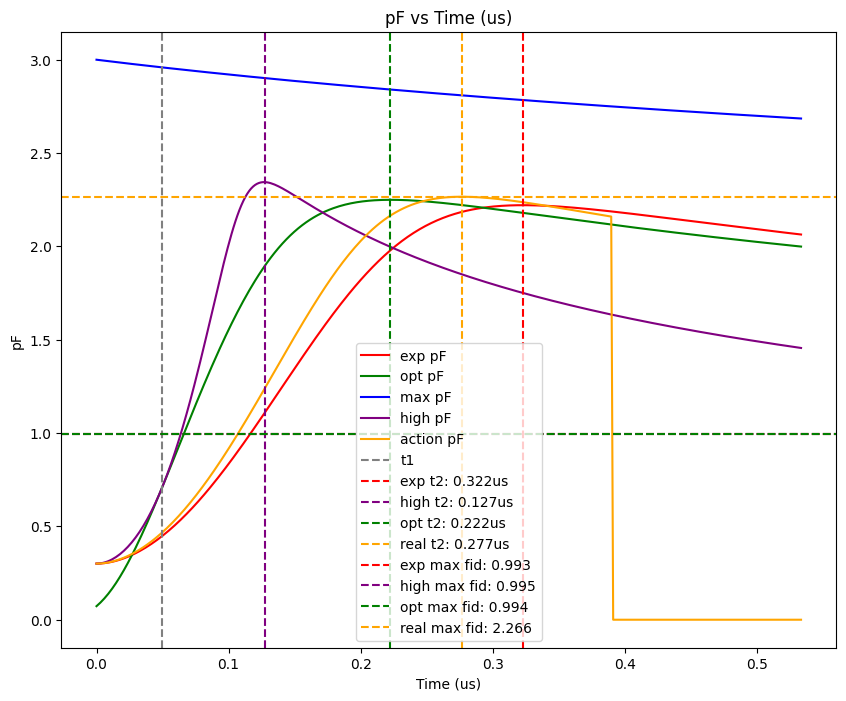

t1: 0.049207490941396335, t2: 0.22222222222222224, t3: 0.03179328393527253
Kappa: 22.5 MHz
1/kappa: 44.44444444444444ns
Normal Measurement Duration: 398.0ns
High Amp Duration (T1): 49.20749094139634ns


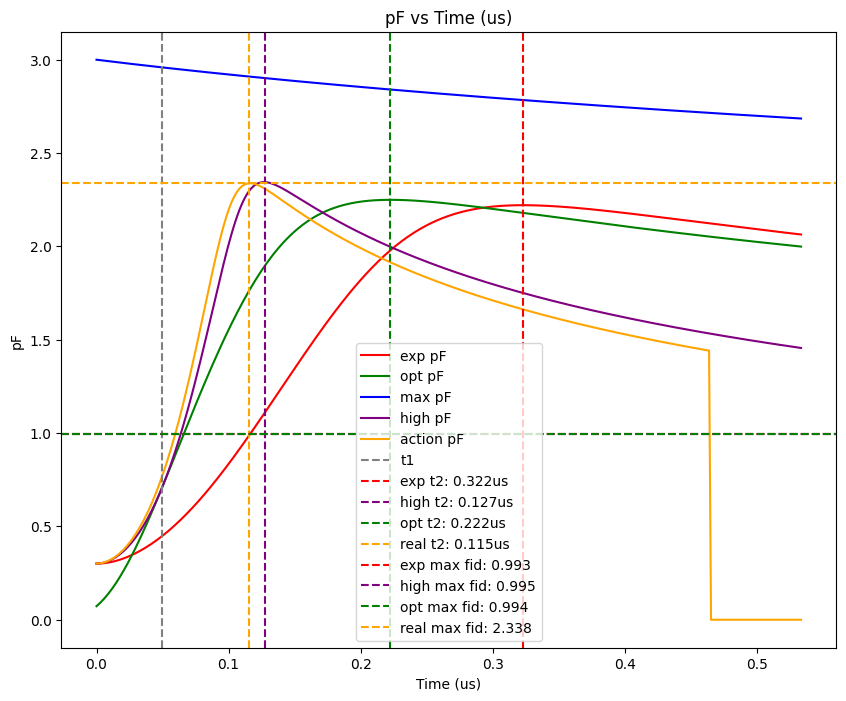

t1: 0.049207490941396335, t2: 0.22222222222222224, t3: 0.03179328393527253


In [10]:
plot_curves = True

action_low = 0.5 * jnp.sqrt(rough_max_photons * (kappa ** 2 + chi ** 2)) * jnp.ones(121)
action_high = 0.5 * rough_max_amp_scaled * jnp.sqrt(rough_max_photons * (kappa ** 2 + chi ** 2)) * jnp.ones(121)

t1, t2, t3 = get_fidelity_curves(
    kappa=kappa * 0.9,
    chi=chi,
    N0=rough_max_photons,
    res_scale_factor=rough_max_amp_scaled,
    tau_0=tau_0,
    init_fid=init_fid,
    gamma_M=gamma_I,
    b=photon_gamma,
    mu_s=scaling_factor,
    num_t1=num_t1,
    plot_curves=plot_curves,
    action=action_low
)
print(f"t1: {t1}, t2: {t2}, t3: {t3}")

t1, t2, t3 = get_fidelity_curves(
    kappa=kappa * 0.9,
    chi=chi,
    N0=rough_max_photons,
    res_scale_factor=rough_max_amp_scaled,
    tau_0=tau_0,
    init_fid=init_fid,
    gamma_M=gamma_I,
    b=photon_gamma,
    mu_s=scaling_factor,
    num_t1=num_t1,
    plot_curves=plot_curves,
    action=action_high
)
print(f"t1: {t1}, t2: {t2}, t3: {t3}")

In [4]:
import jax.numpy as jnp
from jax.scipy.integrate import trapezoid
import matplotlib.pyplot as plt

In [6]:
# Seeding

seed = 30
rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

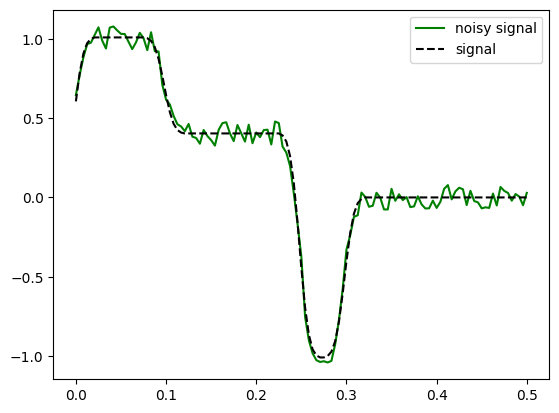

In [53]:
ts = jnp.linspace(0., 0.5, 121)

signal = jnp.heaviside(0.1 - ts, 0.)
signal += 0.4 * (jnp.heaviside(0.25 - ts, 0.) - jnp.heaviside(0.1 - ts, 0.))
signal -= jnp.heaviside(0.3 - ts, 0.) - jnp.heaviside(0.25 - ts, 0.)

temp_dt = ts[1] - ts[0]
kernel_len = 11
std = 2.
small_ts = jnp.linspace(-0.5 * (kernel_len - 1), 0.5 * (kernel_len - 1), kernel_len)
gauss_func = 1 / jnp.sqrt(2 * jnp.pi * std**2) * jnp.exp(-(small_ts / jnp.sqrt(2 * std**2))**2)
gauss_func /= trapezoid(gauss_func, x=small_ts)
signal = jnp.convolve(signal, gauss_func, mode='same')
factor = 0.08
noisy_signal = signal + factor * jax.random.uniform(_rng, signal.shape, minval=-1., maxval=1.)
plt.plot(ts, noisy_signal, color='green', label='noisy signal')
plt.plot(ts, signal, color='black', label='signal', linestyle='dashed')
plt.legend()
plt.show()

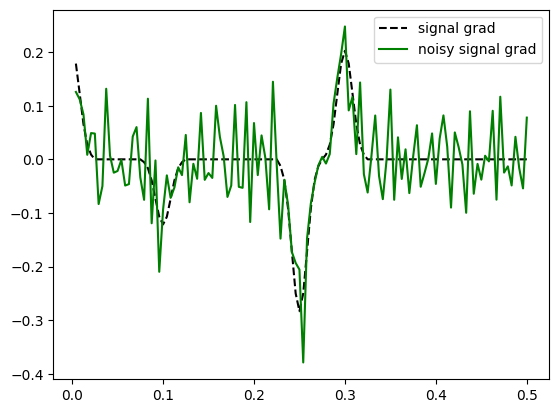

In [54]:
# Calculating first deriv

dt = 1. # for simpler math
signal_grad = jnp.diff(signal, n=1) / dt
noisy_signal_grad = jnp.diff(noisy_signal, n=1) / dt
ts_first = ts[1:]
plt.plot(ts_first, signal_grad, label='signal grad', color='black', linestyle='dashed')
plt.plot(ts_first, noisy_signal_grad, label='noisy signal grad', color='green')
plt.legend()
plt.show()

Signal Integral: 0.0633519844175515
Noisy Signal Integral: 1.2344637263064762


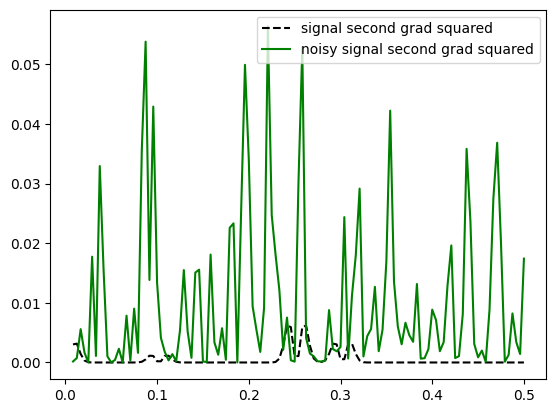

In [50]:
# Plotting Second Deriv Squared

signal_second_grad = jnp.diff(signal_grad) / dt
noisy_signal_second_grad = jnp.diff(noisy_signal_grad) / dt
ts_second = ts[2:]

signal_int = trapezoid((signal_second_grad)**2)
noisy_signal_int = trapezoid((noisy_signal_second_grad)**2)
print(f"Signal Integral: {signal_int}")
print(f"Noisy Signal Integral: {noisy_signal_int}")

plt.plot(ts_second, signal_second_grad ** 2, label='signal second grad squared', color='black', linestyle='dashed')
plt.plot(ts_second, noisy_signal_second_grad ** 2, label='noisy signal second grad squared', color='green')
plt.legend()
plt.show()